This will be an example notebook showing exploratory regression analysis with a simple, point-based hedonic house price model for Baltimore

In [1]:
import pysal as ps
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')
%matplotlib inline

In [2]:
ps.examples.available()

['baltim',
 'juvenile',
 'taz',
 'networks',
 'arcgis',
 'desmith',
 'virginia',
 'nat',
 'sacramento2',
 'Polygon',
 'south',
 'Point',
 'book',
 '10740',
 'chicago',
 'newHaven',
 'sids2',
 'mexico',
 'Line',
 'wmat',
 'street_net_pts',
 'us_income',
 'columbus',
 'burkitt',
 'geodanet',
 'stl',
 'snow_maps',
 'calemp']

In [3]:
ps.examples.explain('baltim')

{'description': 'Baltimore house sales prices and hedonics',
 'explanation': ['* baltim.dbf attribute data',
  '* baltim.shp shape file',
  '* baltim.shx spatial index file',
  '* baltim.tri.k12.kwt Kernel weights using a triangular kernel with 12 neares',
  '  neighbors',
  '* baltim_k4.gwt Nearest neighbor weights (4nn)',
  '* baltim_q.gal Queen contiguity file',
  '* baltimore.geojson',
  'Point data, n=211, k= 17.'],
 'name': 'baltim'}

In [4]:
data = ps.pdio.read_files(ps.examples.get_path('baltim'))

In [5]:
data.head()

,STATION,PRICE,NROOM,DWELL,NBATH,PATIO,FIREPL,AC,BMENT,NSTOR,GAR,AGE,CITCOU,LOTSZ,SQFT,X,Y,geometry
0,1,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,"(907.0, 534.0)"
1,2,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,"(922.0, 574.0)"
2,3,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,2.0,23.0,1.0,70.64,30.62,920.0,581.0,"(920.0, 581.0)"
3,4,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,174.63,26.12,923.0,578.0,"(923.0, 578.0)"
4,5,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,0.0,19.0,1.0,107.80,22.04,918.0,574.0,"(918.0, 574.0)"


In [6]:
mindist = ps.min_threshold_dist_from_shapefile(ps.examples.get_path('baltim.shp'))
mindist

21.319005605327842

In [7]:
W = ps.threshold_binaryW_from_array(np.array([data.X.values, data.Y.values]).T, 2*mindist)

In [8]:
W = ps.W(W.neighbors, W.weights)
W.transform = 'r'

In [9]:
ycols = ['PRICE']
xcols = ['NROOM', 'DWELL', 'LOTSZ', 'SQFT']#, 'AGE']#, 'NBATH', 'PATIO', 'FIREPL', 'AC', 'BMENT', 'NSTOR', 'GAR', ]
y = data[ycols].values
X = data[xcols].values

In [10]:
ols_reg = ps.spreg.OLS(y, X, w=W, spat_diag=True, moran=True, name_y=ycols, 
                       name_x = xcols)

In [11]:
print(ols_reg.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :   ['PRICE']                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :           5
S.D. dependent var  :     23.6061                Degrees of Freedom    :         206
R-squared           :      0.5026
Adjusted R-squared  :      0.4929
Sum squared residual:   58207.850                F-statistic           :     52.0363
Sigma-square        :     282.562                Prob(F-statistic)     :   3.048e-30
S.E. of regression  :      16.810                Log likelihood        :    -892.297
Sigma-square ML     :     275.867                Akaike info criterion :    1794.595
S.E of regression ML:     16.6092                Schwarz criterion     :    1811.354

-----------------------------------------------------------------------------

In [12]:
effects, errs = ols_reg.betas, ols_reg.std_err

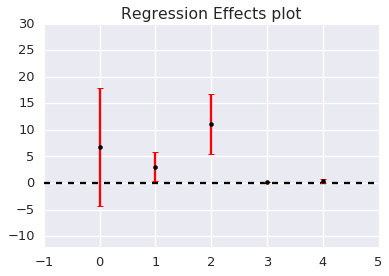

In [13]:
#plt.plot(range(0,len(effects.flatten())), effects.flatten(), '.k')
plt.title('Regression Effects plot')
plt.axis([-1,5, -12,30])
plt.errorbar(range(0,len(effects.flatten())), effects, yerr=errs.flatten()*2, fmt='.k', ecolor='r', capthick=True)
plt.hlines(0, -1, 5, linestyle='--', color='k')

In [14]:
resids = y - ols_reg.predy

In [15]:
Mresids = ps.Moran(resids.flatten(), W)

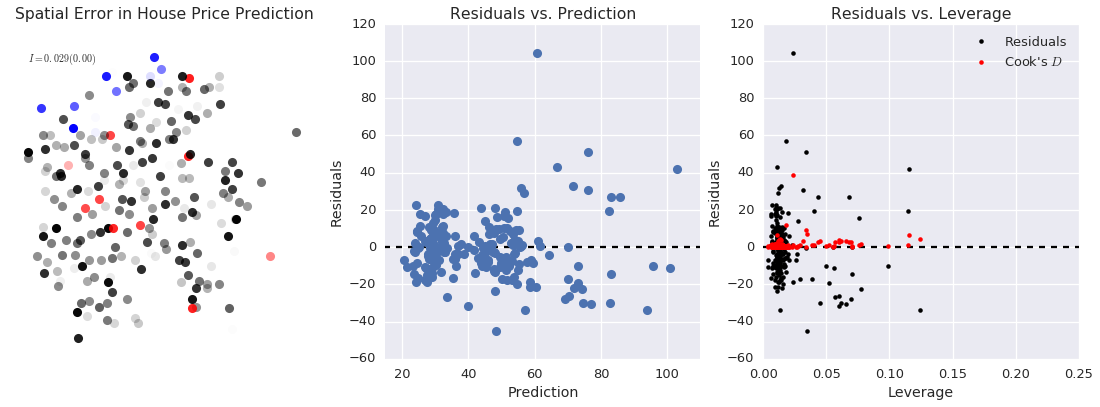

In [16]:
fig, ax = plt.subplots(1,3,figsize=(12*1.6,6))
for xi,yi,alpha in zip(data.X.values, data.Y.values, resids, ):
    if alpha+ ols_reg.std_y < 0:
        color='r'
    elif alpha - ols_reg.std_y > 0:
        color='b'
    else:
        color='k'
    ax[0].plot(xi,yi,color=color, marker='o', alpha = np.abs(alpha))#, alpha=alpha)
ax[0].axis([850, 1000, 500, 590])
ax[0].text(x=860, y=580, s='$I = %.3f (%.2f)$' % (Mresids.I, Mresids.p_sim))


ax[1].plot(ols_reg.predy, resids, 'o')
ax[1].axis([15,110,-60,120])
ax[1].hlines(0,0,150, linestyle='--', color='k')
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Residuals')

H = np.dot(X, np.linalg.inv(np.dot(X.T, X)))
H = np.dot(H, X.T)

lev = H.diagonal().reshape(-1,1)

pref = resids * resids / ((resids.T @ resids) / (X.shape[0] - X.shape[1]))

ax[2].plot(lev, resids, '.k')
ax[2].plot(lev, pref.flatten(), '.r')
ax[2].hlines(0,0,.25,linestyle='--', color='k')
ax[2].set_xlabel('Leverage')
ax[2].set_ylabel('Residuals')
ax[2].legend(labels=['Residuals',"Cook's $D$"])

ax[0].set_axis_bgcolor('white')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_title('Spatial Error in House Price Prediction')
ax[1].set_title('Residuals vs. Prediction')
ax[2].set_title('Residuals vs. Leverage')


plt.show()

In [17]:
ml_lag = ps.spreg.ML_Lag(y, X, w=W)#, name_y=ycols, name_x = xcols)
effects, errs = ml_lag.betas, ml_lag.std_err

/home/ljw/.local/lib/python3.5/site-packages/scipy/optimize/_minimize.py:596: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


In [18]:
print(ml_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :           6
S.D. dependent var  :     23.6061                Degrees of Freedom    :         205
Pseudo R-squared    :      0.5469
Spatial Pseudo R-squared:  0.5443
Sigma-square ML     :     251.400                Log likelihood        :    -883.789
S.E of regression   :      15.856                Akaike info criterion :    1779.578
                                                 Schwarz criterion     :    1799.689

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

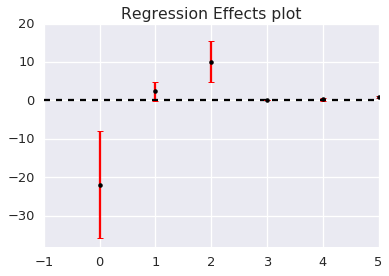

In [23]:
#plt.plot(range(0,len(effects.flatten())), effects.flatten(), '.k')
plt.title('Regression Effects plot')
plt.axis([-1,5, -38,20])
plt.errorbar(range(0,len(effects.flatten())), effects, yerr=errs.flatten()*2, fmt='.k', ecolor='r', capthick=True)
plt.hlines(0, -1, 13, linestyle='--', color='k')

In [24]:
resids = y - ml_lag.predy
Mresids = ps.Moran(resids.flatten(), W)

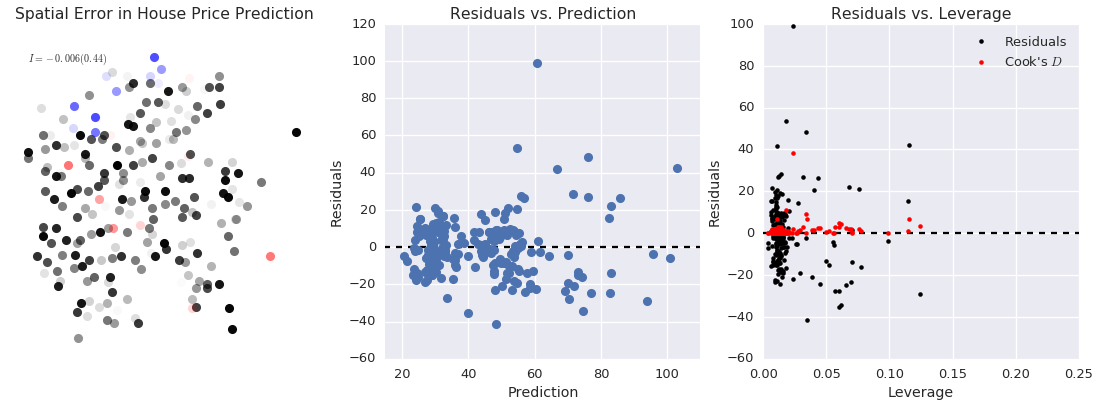

In [25]:
fig, ax = plt.subplots(1,3,figsize=(12*1.6,6))
for xi,yi,alpha in zip(data.X.values, data.Y.values, resids):
    if alpha+ ols_reg.std_y < 0:
        color='r'
    elif alpha - ols_reg.std_y > 0:
        color='b'
    else:
        color='k'
    ax[0].plot(xi,yi,color=color, marker='o', alpha = np.abs(alpha))#, alpha=alpha)
ax[0].axis([850, 1000, 500, 590])
ax[0].text(x=860, y=580, s='$I = %.3f (%.2f)$' % (Mresids.I, Mresids.p_sim))



ax[1].plot(ols_reg.predy, resids, 'o')
ax[1].axis([15,110,-60,120])
ax[1].hlines(0,0,150, linestyle='--', color='k')
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Residuals')

H = np.dot(X, np.linalg.inv(np.dot(X.T, X)))
H = np.dot(H, X.T)

lev = H.diagonal().reshape(-1,1)

pref = resids * resids / ((resids.T @ resids) / (X.shape[0] - X.shape[1]))

ax[2].plot(lev, resids, '.k')
ax[2].plot(lev, pref.flatten(), '.r')
ax[2].hlines(0,0,.25,linestyle='--', color='k')
ax[2].set_xlabel('Leverage')
ax[2].set_ylabel('Residuals')
ax[2].legend(labels=['Residuals',"Cook's $D$"])

ax[0].set_axis_bgcolor('white')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_title('Spatial Error in House Price Prediction')
ax[1].set_title('Residuals vs. Prediction')
ax[2].set_title('Residuals vs. Leverage')


plt.show()

In [26]:
xcols.append('AGE')

In [27]:
X = data[xcols].values

In [28]:
reg_ommit = ps.spreg.OLS(y,X, name_y = ycols, name_x = xcols)
effects, errs = reg_ommit.betas, reg_ommit.std_err
print(reg_ommit.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   ['PRICE']                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :           6
S.D. dependent var  :     23.6061                Degrees of Freedom    :         205
R-squared           :      0.5585
Adjusted R-squared  :      0.5478
Sum squared residual:   51659.953                F-statistic           :     51.8746
Sigma-square        :     252.000                Prob(F-statistic)     :   1.339e-34
S.E. of regression  :      15.875                Log likelihood        :    -879.707
Sigma-square ML     :     244.834                Akaike info criterion :    1771.414
S.E of regression ML:     15.6472                Schwarz criterion     :    1791.526

-----------------------------------------------------------------------------

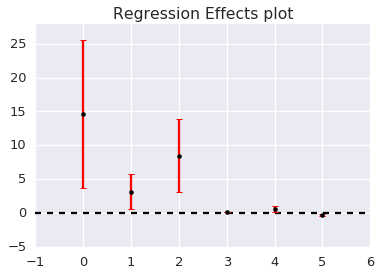

In [31]:
#plt.plot(range(0,len(effects.flatten())), effects.flatten(), '.k')
plt.title('Regression Effects plot')
plt.axis([-1,6, -5,28])
plt.errorbar(range(0,len(effects.flatten())), effects, yerr=errs.flatten()*2, fmt='.k', ecolor='r', capthick=True)
plt.hlines(0, -1, 13, linestyle='--', color='k')

In [32]:
resids = y - reg_ommit.predy
Mresids = ps.Moran(resids.flatten(), W)

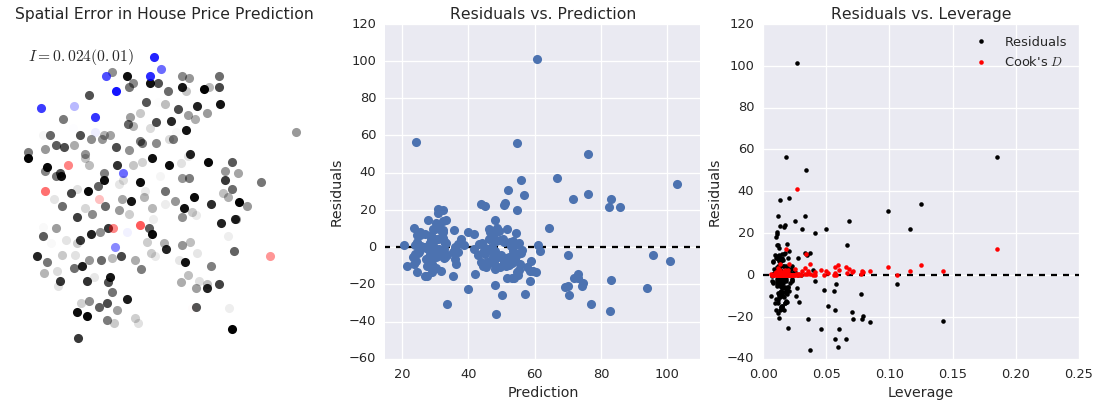

In [33]:
sns.set_context('talk')
fig, ax = plt.subplots(1,3,figsize=(12*1.6,6))
for xi,yi,alpha in zip(data.X.values, data.Y.values, resids, ):
    if alpha+ ols_reg.std_y < 0:
        color='r'
    elif alpha - ols_reg.std_y > 0:
        color='b'
    else:
        color='k'
    ax[0].plot(xi,yi,color=color, marker='o', alpha = np.abs(alpha))#, alpha=alpha)
ax[0].axis([850, 1000, 500, 590])
ax[0].text(x=860, y=580, s='$I = %.3f (%.2f)$' % (Mresids.I, Mresids.p_sim))



ax[1].plot(ols_reg.predy, resids, 'o')
ax[1].axis([15,110,-60,120])
ax[1].hlines(0,0,150, linestyle='--', color='k')
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Residuals')

H = np.dot(X, np.linalg.inv(np.dot(X.T, X)))
H = np.dot(H, X.T)

lev = H.diagonal().reshape(-1,1)

pref = resids * resids / ((resids.T @ resids) / (X.shape[0] - X.shape[1]))

ax[2].plot(lev, resids, '.k')
ax[2].plot(lev, pref.flatten(), '.r')
ax[2].hlines(0,0,.25,linestyle='--', color='k')
ax[2].set_xlabel('Leverage')
ax[2].set_ylabel('Residuals')
ax[2].legend(labels=['Residuals',"Cook's $D$"])

ax[0].set_axis_bgcolor('white')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_title('Spatial Error in House Price Prediction')
ax[1].set_title('Residuals vs. Prediction')
ax[2].set_title('Residuals vs. Leverage')


plt.show()

In [34]:
xcols.extend(['NBATH', 'PATIO', 'FIREPL', 'AC', 'BMENT', 'NSTOR', 'GAR', ])
X = data[xcols].values
reg_ommit = ps.spreg.OLS(y,X, name_y = ycols, name_x = xcols)
effects, errs = reg_ommit.betas, reg_ommit.std_err
resids = y - reg_ommit.predy
print(reg_ommit.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   ['PRICE']                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :          13
S.D. dependent var  :     23.6061                Degrees of Freedom    :         198
R-squared           :      0.6946
Adjusted R-squared  :      0.6761
Sum squared residual:   35734.671                F-statistic           :     37.5332
Sigma-square        :     180.478                Prob(F-statistic)     :   1.512e-44
S.E. of regression  :      13.434                Log likelihood        :    -840.824
Sigma-square ML     :     169.359                Akaike info criterion :    1707.648
S.E of regression ML:     13.0138                Schwarz criterion     :    1751.222

-----------------------------------------------------------------------------

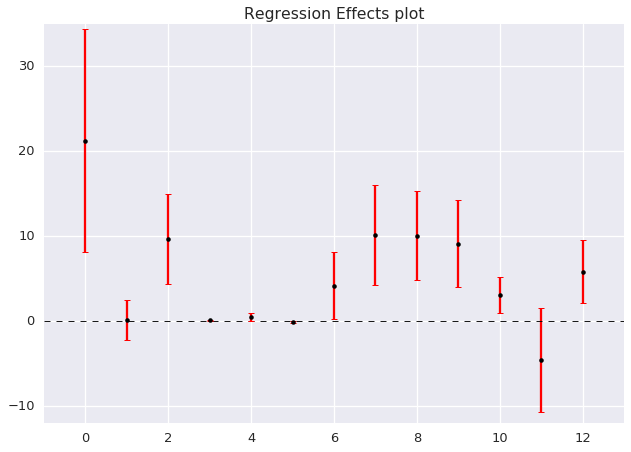

In [42]:
#plt.plot(range(0,len(effects.flatten())), effects.flatten(), '.k')
plt.title('Regression Effects plot')
plt.axis([-1,13, -12,35])
plt.errorbar(range(0,len(effects.flatten())), effects, yerr=errs.flatten()*2, fmt='.k', ecolor='r', capthick=True)
plt.hlines(0, -1, 13, linestyle='--', color='k', linewidth=.9)

In [43]:
Mresids = ps.Moran(resids, W)

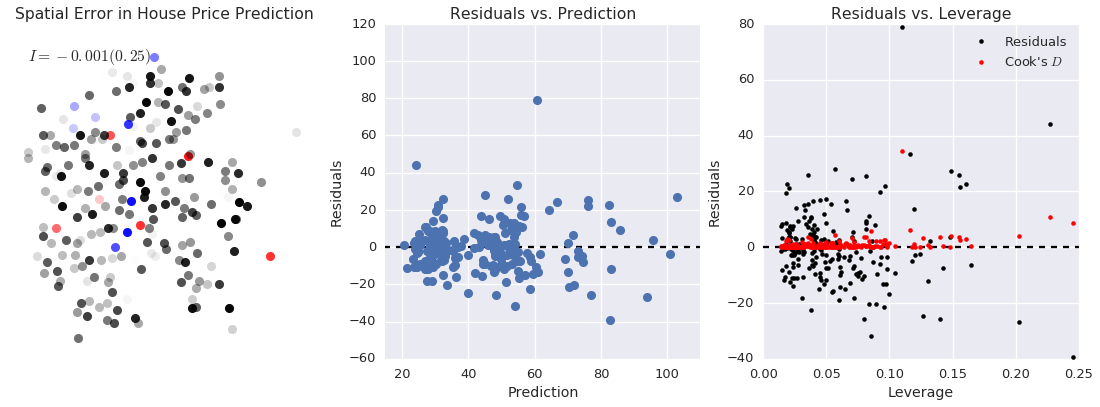

In [44]:
sns.set_context('talk')
fig, ax = plt.subplots(1,3,figsize=(12*1.6,6))
for xi,yi,alpha in zip(data.X.values, data.Y.values, resids, ):
    if alpha+ ols_reg.std_y < 0:
        color='r'
    elif alpha - ols_reg.std_y > 0:
        color='b'
    else:
        color='k'
    ax[0].plot(xi,yi,color=color, marker='o', alpha = np.abs(alpha))#, alpha=alpha)
ax[0].axis([850, 1000, 500, 590])
ax[0].text(x=860, y=580, s='$I = %.3f (%.2f)$' % (Mresids.I, Mresids.p_sim))


ax[1].plot(ols_reg.predy, resids, 'o')
ax[1].axis([15,110,-60,120])
ax[1].hlines(0,0,150, linestyle='--', color='k')
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Residuals')


H = np.dot(X, np.linalg.inv(np.dot(X.T, X)))
H = np.dot(H, X.T)

lev = H.diagonal().reshape(-1,1)

pref = resids * resids / ((resids.T @ resids) / (X.shape[0] - X.shape[1]))

ax[2].plot(lev, resids, '.k')
ax[2].plot(lev, pref.flatten(), '.r')
ax[2].hlines(0,0,.25,linestyle='--', color='k')
ax[2].set_xlabel('Leverage')
ax[2].set_ylabel('Residuals')
ax[2].legend(labels=['Residuals',"Cook's $D$"])

ax[0].set_axis_bgcolor('white')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_title('Spatial Error in House Price Prediction')
ax[1].set_title('Residuals vs. Prediction')
ax[2].set_title('Residuals vs. Leverage')


plt.show()

In [45]:
reg_ommit = ps.spreg.ML_Lag(y,X, w=W)
effects, errs = reg_ommit.betas, reg_ommit.std_err
resids = y - reg_ommit.predy
print(reg_ommit.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         211
Mean dependent var  :     44.3072                Number of Variables   :          14
S.D. dependent var  :     23.6061                Degrees of Freedom    :         197
Pseudo R-squared    :      0.7002
Spatial Pseudo R-squared:  0.7023
Sigma-square ML     :     166.248                Log likelihood        :    -839.044
S.E of regression   :      12.894                Akaike info criterion :    1706.088
                                                 Schwarz criterion     :    1753.014

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

/home/ljw/.local/lib/python3.5/site-packages/scipy/optimize/_minimize.py:596: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  "defaulting to absolute tolerance.", RuntimeWarning)


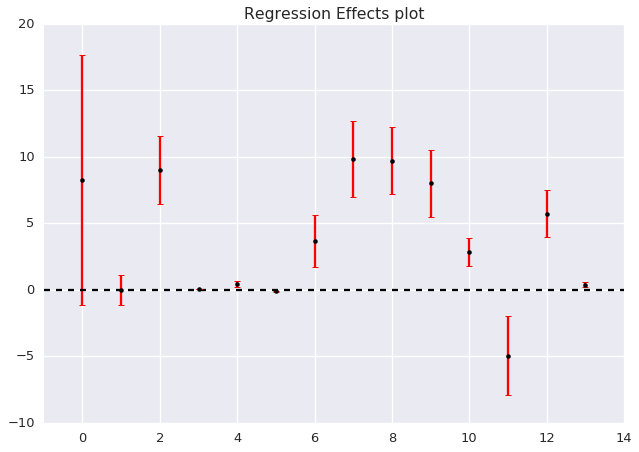

In [47]:
#plt.plot(range(0,len(effects.flatten())), effects.flatten(), '.k')
plt.title('Regression Effects plot')
plt.axis([-1,14, -10,20])
plt.errorbar(range(0,len(effects.flatten())), effects, yerr=errs.flatten(), fmt='.k', ecolor='r', capthick=True)
plt.hlines(0, -1, 14, linestyle='--', color='k')

In [48]:
Mresids = ps.Moran(resids, W)

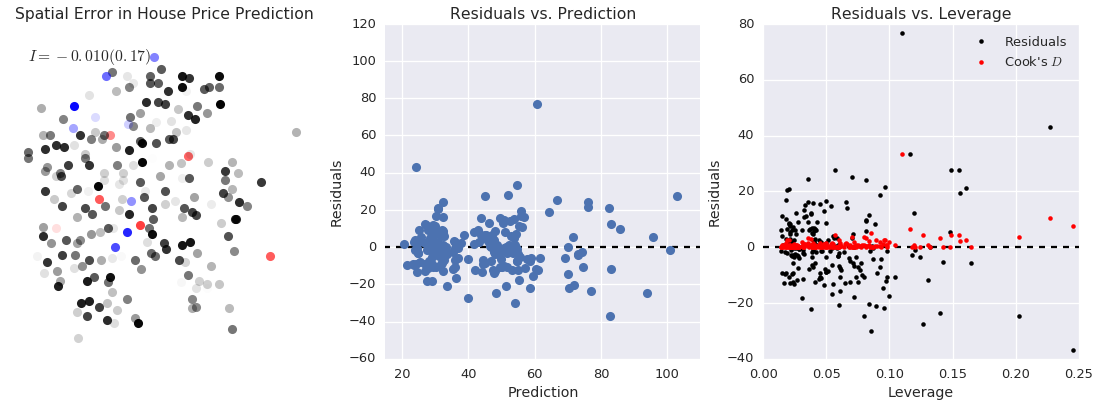

In [49]:
sns.set_context('talk')
fig, ax = plt.subplots(1,3,figsize=(12*1.6,6))
for xi,yi,alpha in zip(data.X.values, data.Y.values, resids, ):
    if alpha+ ols_reg.std_y < 0:
        color='r'
    elif alpha - ols_reg.std_y > 0:
        color='b'
    else:
        color='k'
    ax[0].plot(xi,yi,color=color, marker='o', alpha = np.abs(alpha))#, alpha=alpha)
ax[0].axis([850, 1000, 500, 590])
ax[0].text(x=860, y=580, s='$I = %.3f (%.2f)$' % (Mresids.I, Mresids.p_sim))


ax[1].plot(ols_reg.predy, resids, 'o')
ax[1].axis([15,110,-60,120])
ax[1].hlines(0,0,150, linestyle='--', color='k')
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Residuals')


H = np.dot(X, np.linalg.inv(np.dot(X.T, X)))
H = np.dot(H, X.T)

lev = H.diagonal().reshape(-1,1)

pref = resids * resids / ((resids.T @ resids) / (X.shape[0] - X.shape[1]))

ax[2].plot(lev, resids, '.k')
ax[2].plot(lev, pref.flatten(), '.r')
ax[2].hlines(0,0,.25,linestyle='--', color='k')
ax[2].set_xlabel('Leverage')
ax[2].set_ylabel('Residuals')
ax[2].legend(labels=['Residuals',"Cook's $D$"])

ax[0].set_axis_bgcolor('white')
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_title('Spatial Error in House Price Prediction')
ax[1].set_title('Residuals vs. Prediction')
ax[2].set_title('Residuals vs. Leverage')


plt.show()